In [1]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from d2l import torch as d2l

In [2]:
# traindSet = csf(csv_path='original_train_set.pkl', mode='train')
# trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout),
            # nn.Linear(256 * 6 * 6, 4096),
            # nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            # nn.Linear(4096, 4096),
            # nn.ReLU(inplace=True),
            # nn.Linear(4096, num_classes),
            nn.Dropout(p=dropout),
            nn.Linear(256 * 1 * 4, 2048), nn.ReLU(), ### 这边需要改，输入的大小
            nn.Dropout(p=0.5),
            nn.Linear(2048, 1024), nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 16), nn.ReLU(),
            nn.Linear(16, num_classes), nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
model = AlexNet()

In [11]:
for X, y in testloader:
    print(X.shape)
    pred = model(X)
    print(pred.shape)
    print(y.shape)
    break

torch.Size([256, 1, 1, 152])
torch.Size([256, 1])
torch.Size([256, 1])


In [4]:
net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1, 7), stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(64, 192, kernel_size=(1, 5)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1, 3), stride=2),
            nn.Conv2d(192, 384, kernel_size=(1, 3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(1,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size= (1, 3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (1, 3), stride=2),
        )

In [5]:
net

Sequential(
  (0): Conv2d(1, 64, kernel_size=(1, 7), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=(1, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(1, 5), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=(1, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(1, 3), stride=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(1, 3), stride=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(1, 3), stride=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=(1, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [3]:
net = nn.Sequential(
    nn.Linear(152, 1024), nn.ReLU(),
    nn.Linear(1024, 2048), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(256, 64), nn.ReLU(),
    nn.Linear(64, 16), nn.ReLU(),
    nn.Linear(16, 1), nn.Sigmoid())

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

In [5]:
def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

loss 0.676, train acc 0.584, test acc 0.619


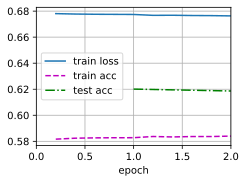

In [8]:
lr = 0.3
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
# net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

loss 0.665, train acc 0.603, test acc 0.576


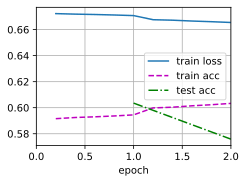

In [9]:
lr = 0.1
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
# net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

loss 0.638, train acc 0.645, test acc 0.565


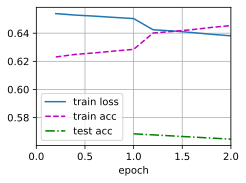

In [10]:
lr = 0.05
epochs = 2
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
# net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

loss 0.568, train acc 0.724, test acc 0.532


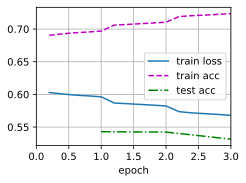

In [11]:
lr = 0.005
epochs = 3
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[0, epochs],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
# net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())